## 作业1：跳伞运动员仿真
   一名高空跳伞运动员从飞机上跳下，能够确定海拔高度和运动员自由下落的速度吗？在上一个实例中，炮弹总是保持$500m/s$的水平初速度（知道落入海中）。实际情况下，空气的摩擦阻力将使炮弹减速。同样，作用在运动员身上的重力同样受到空气摩擦力的影响，并随着运动员速度的增加而变大。最终，这一阻力将导致向上的摩擦力与向下的重力平衡，使合外力为零。在这一点，运动员将不再加速并保持稳态速度。
    根据基本空气动力学理论，运动员所受阻力由下式表示：
$$drag={1\over2}\rho v^2SC_d$$
式中，$\rho$为空气密度，$v$为速度，$S$为表面积，$C_d$为阻力系数。
    该公式的计算显然比较复杂。首先，空气密度$\rho$随着海拔高度而变化；第二，总阻力随着速度的平方变化；第三，运动员的表面积随着其运动而变化；最后，阻力系数取决于运动员伞具采用材料的摩擦力系数。这四个变量都是非线性的，因此很难推导出这个公式的显式解。
    为简化这个问题，假设$\rho=1.225kg/m^3$，$S=1.0m^2$，$C_d=0.05$，因此仅有$v$为非线性项。使用Euler法模拟整个运动过程，而不是直接求解公式。
    改变伞打开的时间，观察跳伞运动员的运动状态变化。

In [13]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *
import numpy as np
import pandas as pd

In [14]:
kg=UNITS.kg
m = UNITS.meter
s = UNITS.second
g = 9.8 * m/s**2  
weight=85*kg
density=1.225*kg/m**3  #密度
S=1.0*m**2 #面积
Cd=0.05   #阻力系数
t_open=15*s  #开伞时间
dt=0.01*s    #步长
height=3000.0*m
t_end=30*s

init_z = State(y=3000.0 * m, v=0.0 * m/s)
system_z = System(init=init_z, g=g, t_end=t_open, dt=dt)

,values
init,y 3000.0 meter v 0.0 meter / secon...
g,9.8 meter / second ** 2
t_end,15 second
dt,0.01 second


In [15]:
def slope_func_z(state, t, system):
    y, v = state
    
    dydt = v
    dvdt = -system.g
    
    return dydt, dvdt

def slope_func_z_open(state, t, system):
    y, v = state
    drag=0.5*density*v*v*S*Cd
    dydt = v
    dvdt =drag/weight -system.g
    
    return dydt, dvdt

##  方法一

In [16]:
results_z, details_z= run_euler(system_z, slope_func_z)
system_z_open = System(init=results_z.iloc[-1], g=g, t_0=t_open, t_end=t_end, dt=dt)
results_z_after, details_z= run_euler(system_z_open, slope_func_z_open)
results_z_final=pd.concat([results_z,results_z_after])

,y,v
0.00,3000.0 meter,0.0 meter / second
0.01,3000.0 meter,-0.098 meter / second
0.02,2999.99902 meter,-0.196 meter / second
0.03,2999.99706 meter,-0.29400000000000004 meter / second
0.04,2999.9941200000003 meter,-0.392 meter / second
...,...,...
29.96,-440.7491878963455 meter,-161.75500292138278 meter / second
29.97,-442.36673792555933 meter,-161.7587331149464 meter / second
29.98,-443.9843252567088 meter,-161.76245896059282 meter / second
29.99,-445.60194984631477 meter,-161.76618046328988 meter / second


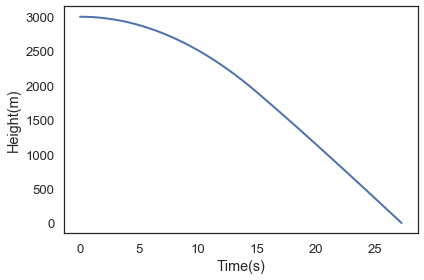

In [17]:
plot(results_z_final[results_z_final.y>0].y)
decorate(xlabel='Time(s)',
         ylabel='Height(m)')

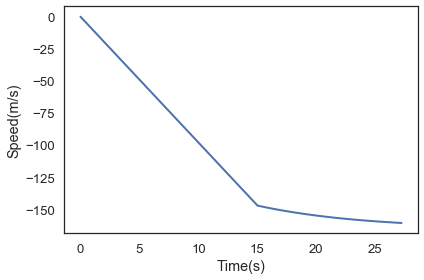

In [18]:
plot(results_z_final[results_z_final.y>0].v)
decorate(xlabel='Time(s)',
         ylabel='Speed(m/s)')

## 方法二

In [19]:
def run_euler_reversed(system, slope_func, results=0,count=0.0,**options):
    """Computes a numerical solution to a differential equation.

    `system` must contain `init` with initial conditions,
    `t_end` with the end time, and `dt` with the time step.

    `system` may contain `t_0` to override the default, 0

    It can contain any other parameters required by the slope function.

    `options` can be ...

    system: System object
    slope_func: function that computes slopes

    returns: TimeFrame
    """
    # the default message if nothing changes
    msg = "The solver successfully reached the end of the integration interval."

    # get parameters from system
    init, t_0, t_end, dt = check_system(system, slope_func)

    # make the TimeFrame
    if count==0:
        frame = TimeFrame(columns=init.index)
        frame.row[t_0] = init
        ts = linrange(t_0, t_end, dt) * get_units(t_end)
        # run the solver
        for t1 in ts: 
            y1 = frame.row[t1]
            if y1.y<=0:   #检查高度是否大于零
                break
            else:
                slopes = slope_func(y1, t1, system)
                y2 = [y + slope * dt for y, slope in zip(y1, slopes)]
                t2 = t1 + dt
                frame.row[t2] = y2
                count=t2
    else:
        frame=results
        ts = linrange(count, t_end, dt) * get_units(t_end)
        # run the solver
        for t1 in ts:
            y1 = frame.row[t1]
            if y1.y<=0:   #检查高度是否大于零
                break
            else:
                slopes = slope_func(y1, t1, system)
                y2 = [y + slope * dt for y, slope in zip(y1, slopes)]
                t2 = t1 + dt
                frame.row[t2] = y2
                count=t2
         
    details = ModSimSeries(dict(message="Success"))
    return frame, details,count

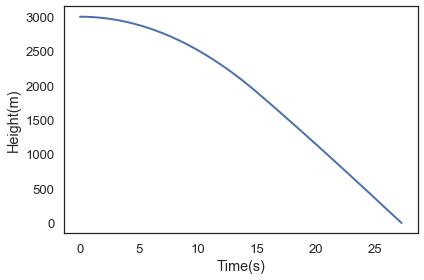

In [20]:
results_z, details_z, count = run_euler_reversed(system_z, slope_func_z)
system_z_open = System(init=results_z.row[count], g=g, t_0=t_open, t_end=t_end, dt=dt)
results_z_fianl, details_z, count_final = run_euler_reversed(system_z_open, slope_func_z_open, results_z, count)
plot(results_z.y)
decorate(xlabel='Time(s)',
         ylabel='Height(m)')

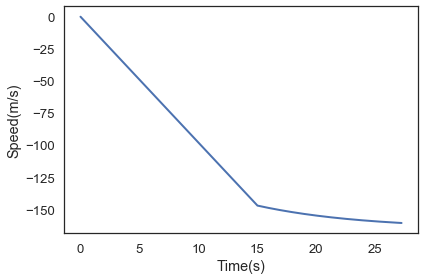

In [21]:
plot(results_z.v)
decorate(xlabel='Time(s)',
         ylabel='Speed(m/s)')